## Distributed Computing Final Project File

### Authors: Clarence Williams, Lingzhen Zhu, Ethan Nelson

### 1. Data Import & Pre-Processing (2 pts)

#### 1a. Data Importing
* Our data comes from the nfl_data_py package. First, we import the package to access the data.

In [1]:
import nfl_data_py as nfl

In [2]:
years = []

# loop through years from 2000 to 2023
for i in range(2000,2024):
    years.append(i)

# removing game_date, removing time
# play_type is the predictor col
cols = ["home_team", "away_team", "season_type", "week", "posteam", "posteam_type", 
        "defteam", "side_of_field", "yardline_100", "quarter_seconds_remaining", 
        "half_seconds_remaining", "game_seconds_remaining" , "game_half", "down", 
        "drive", "qtr",  "ydstogo", "play_type", "posteam_timeouts_remaining", 
        "defteam_timeouts_remaining", "posteam_score", "defteam_score", "score_differential", 
        "ep", "epa", "season"]

#TODO add weather to col

data = nfl.import_pbp_data(years, downcast=False, cache=False, alt_path=None)

2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.


In [3]:
# get the desired columns
reduced_data = data.filter(items=cols) 

In [4]:
# select only where there are 4th downs
forth_down = reduced_data.query("down==4.0")

In [5]:
# get counts for play types by season
eda_data = forth_down.groupby(["season", "play_type"])['play_type'].count().reset_index(name='total_count')
eda_data = eda_data.sort_values(by=["season","total_count"], ascending=False)
eda_data

season   play_type  total_count
139    2023        punt         2352
136    2023  field_goal         1037
138    2023        pass          525
141    2023         run          308
137    2023     no_play          253
..      ...         ...          ...
3      2000        punt         2579
0      2000  field_goal          869
2      2000        pass          291
1      2000     no_play          208
4      2000         run          179

[142 rows x 3 columns]

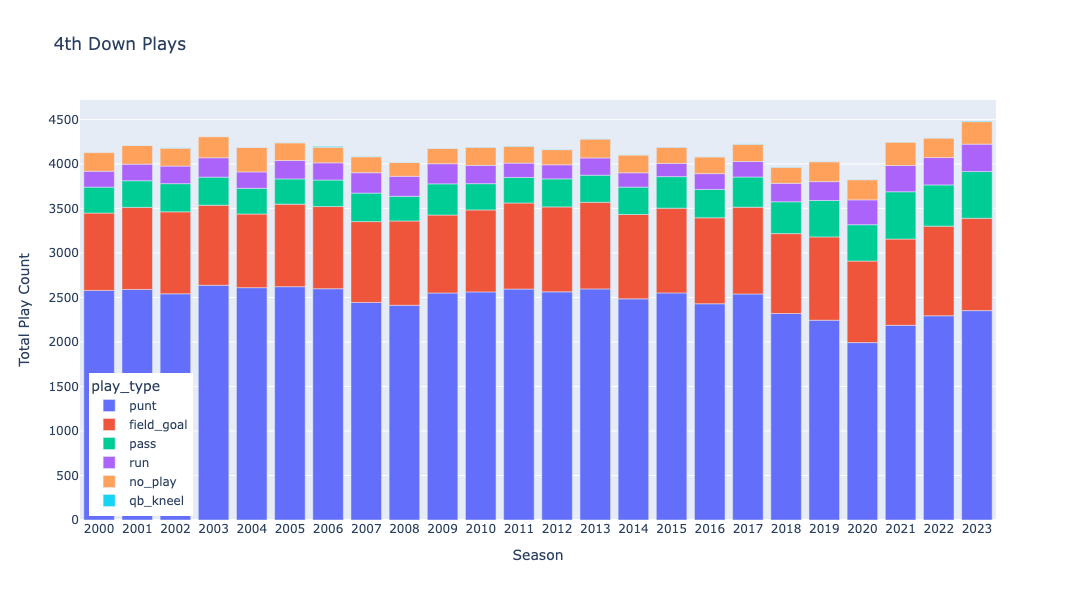

In [16]:
import plotly.express as px

# visualize with plotly
fig = px.bar(eda_data, x="season", y="total_count", color="play_type", title="4th Down Plays", width=1200, height=600)

fig.update_xaxes(
    tickmode='array',
    tickvals=years,  # Specify the desired tick values
    ticktext=years, # Specify the corresponding labels
)

# '''
fig.update_layout(
    legend=dict(
            yanchor="bottom",
            y=0.01,
            xanchor="left",
            x=0.01
        ),
    xaxis_title = 'Season',
    yaxis_title = 'Total Play Count'
)
# '''

fig.show()


In [7]:
forth_down["play_type"].unique()

array(['punt', 'no_play', 'run', None, 'field_goal', 'pass', 'qb_kneel'],
      dtype=object)

In [8]:
#forth_down.to_csv('forth_down_3.csv', index=False)
forth_down.shape

(100225, 26)

#### 1b. Create spark dataframe for 4th down data

In [9]:
from pyspark.sql import SparkSession

# set up the session
spark = SparkSession.builder.getOrCreate()

# Convert to PySpark DataFrame
spark_df = spark.createDataFrame(forth_down)
#spark_df = spark.createDataFrame(reduced_data)

# Show the PySpark DataFrame
#spark_df.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/30 14:01:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [10]:
spark_df.groupBy("play_type").count().show()
#spark_df["play_type"].distinct()

24/11/30 14:01:42 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/11/30 14:01:43 WARN TaskSetManager: Stage 0 contains a task of very large size (8310 KiB). The maximum recommended task size is 1000 KiB.


+----------+-----+
| play_type|count|
+----------+-----+
|field_goal|22437|
|      null|  226|
|   no_play| 4912|
|  qb_kneel|   75|
|       run| 5034|
|      punt|59290|
|      pass| 8251|
+----------+-----+



#### 1c. Removing records with null plays

In [11]:
from pyspark.sql.functions import col

spark_df = spark_df.where(col("play_type").isNotNull())

spark_df.groupBy("play_type").count().show()

24/11/30 14:01:45 WARN TaskSetManager: Stage 3 contains a task of very large size (8310 KiB). The maximum recommended task size is 1000 KiB.


+----------+-----+
| play_type|count|
+----------+-----+
|field_goal|22437|
|   no_play| 4912|
|  qb_kneel|   75|
|       run| 5034|
|      punt|59290|
|      pass| 8251|
+----------+-----+



#### 1d. Removing records with qb_kneel on 4th down

In [12]:
spark_df = spark_df.where(col("play_type") != "qb_kneel")

spark_df.groupBy("play_type").count().show()

24/11/30 14:01:46 WARN TaskSetManager: Stage 6 contains a task of very large size (8310 KiB). The maximum recommended task size is 1000 KiB.


+----------+-----+
| play_type|count|
+----------+-----+
|field_goal|22437|
|   no_play| 4912|
|       run| 5034|
|      punt|59290|
|      pass| 8251|
+----------+-----+



### 2. Data Splitting / Sampling (1 Point)

#### 2a. Actual Split

In [13]:
# out sampling fractions
fractions = {
    "field_goal": 0.6,
    "no_play": 0.6,
    "run": 0.6,
    "punt": 0.4,
    "pass": 0.6
}

# get the sample
train_df = spark_df.sampleBy("play_type", fractions=fractions, seed=42)

# remove sample to form the test
test_df = spark_df.subtract(train_df)

In [14]:
# get the counts per play for train
train_df.groupBy("play_type").count().show()

24/11/30 14:01:47 WARN TaskSetManager: Stage 9 contains a task of very large size (8310 KiB). The maximum recommended task size is 1000 KiB.


+----------+-----+
| play_type|count|
+----------+-----+
|field_goal|13506|
|   no_play| 2967|
|       run| 3035|
|      punt|23800|
|      pass| 4970|
+----------+-----+



In [15]:
# get the counts per play for test
test_df.groupBy("play_type").count().show()

24/11/30 14:01:48 WARN TaskSetManager: Stage 12 contains a task of very large size (8310 KiB). The maximum recommended task size is 1000 KiB.
24/11/30 14:01:49 WARN TaskSetManager: Stage 13 contains a task of very large size (8310 KiB). The maximum recommended task size is 1000 KiB.


+----------+-----+
| play_type|count|
+----------+-----+
|field_goal| 8931|
|   no_play| 1945|
|       run| 1999|
|      punt|35490|
|      pass| 3281|
+----------+-----+



In [16]:
str_col = ["home_team", "away_team", "season_type", "posteam", "posteam_type", "defteam", "side_of_field", "game_half",
            "play_type", "season"]
str_col_output = ["home_team_idx", "away_team_idx", "season_type_idx", "posteam_idx", "posteam_type_idx", "defteam_idx",
                  "side_of_field_idx", "game_half_idx", "play_type_idx", "season_idx"]
ohe_col_input = ["home_team_idx", "away_team_idx", "season_type_idx", "posteam_idx", "posteam_type_idx", "defteam_idx",
                  "side_of_field_idx", "game_half_idx", "season_idx"]
ohe_col_vec = ["home_team_vec", "away_team_vec", "season_type_vec", "posteam_vec", "posteam_type_vec", "defteam_vec",
                  "side_of_field_vec", "game_half_ivec", "season_vec"]


#### 2b. Under sample majority class (punt)

In [17]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
import pandas as pd
from imblearn.combine import SMOTEENN


# Convert PySpark DataFrame to pandas DataFrame
pandas_df = train_df.toPandas()


# Undersample the data
rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)


X_resampled, y_resampled = rus.fit_resample(pandas_df.drop("play_type", axis=1), pandas_df["play_type"])

pandas_df.drop("play_type", axis=1, inplace=True)

# Convert back to PySpark DataFrame
undersampled_df = spark.createDataFrame(pd.DataFrame(X_resampled, columns=pandas_df.columns).assign(play_type=y_resampled))
undersampled_df.groupBy("play_type").count().show()

24/11/30 14:01:59 WARN TaskSetManager: Stage 26 contains a task of very large size (8310 KiB). The maximum recommended task size is 1000 KiB.
24/11/30 14:02:04 WARN TaskSetManager: Stage 27 contains a task of very large size (2683 KiB). The maximum recommended task size is 1000 KiB.


+----------+-----+
| play_type|count|
+----------+-----+
|field_goal|13506|
|   no_play| 2967|
|       run| 3035|
|      punt| 2967|
|      pass| 4970|
+----------+-----+



#### 2c. Under sample majority class (field goal)

In [18]:
# Convert PySpark DataFrame to pandas DataFrame
pandas_df = undersampled_df.toPandas()


# Undersample the data
rus2 = RandomUnderSampler(sampling_strategy='majority', random_state=42)


X_resampled, y_resampled = rus2.fit_resample(pandas_df.drop("play_type", axis=1), pandas_df["play_type"])

pandas_df.drop("play_type", axis=1, inplace=True)

# Convert back to PySpark DataFrame
undersampled_df2 = spark.createDataFrame(pd.DataFrame(X_resampled, columns=pandas_df.columns).assign(play_type=y_resampled))
undersampled_df2.groupBy("play_type").count().show()

24/11/30 14:02:05 WARN TaskSetManager: Stage 30 contains a task of very large size (2683 KiB). The maximum recommended task size is 1000 KiB.
24/11/30 14:02:07 WARN TaskSetManager: Stage 31 contains a task of very large size (1631 KiB). The maximum recommended task size is 1000 KiB.


+----------+-----+
| play_type|count|
+----------+-----+
|field_goal| 2967|
|   no_play| 2967|
|      pass| 4970|
|       run| 3035|
|      punt| 2967|
+----------+-----+



#### 2d. Oversample all classes but pass

In [19]:
str_col2 = ["home_team", "away_team", "season_type", "posteam", "posteam_type", "defteam", "side_of_field", "game_half", "season"]

# Convert PySpark DataFrame to pandas DataFrame
pandas_df = undersampled_df2.toPandas()
pandas_df2 = pandas_df.copy()
pandas_df2.drop("play_type", axis=1, inplace=True)
print(pandas_df2.columns)
categorical_indices = [pandas_df2.columns.get_loc(col) for col in str_col2]

print(categorical_indices)


# Define SMOTENC with indices of categorical columns
smote_enn = SMOTENC(categorical_features=categorical_indices, random_state=42)
#X_resampled, y_resampled = rus.fit_resample(pandas_df.drop("play_type", axis=1), pandas_df["play_type"])
X_resampled, y_resampled = smote_enn.fit_resample(pandas_df.drop("play_type", axis=1), pandas_df["play_type"])
pandas_df.drop("play_type", axis=1, inplace=True)

# Convert back to PySpark DataFrame
undersampled_df3 = spark.createDataFrame(pd.DataFrame(X_resampled, columns=pandas_df.columns).assign(play_type=y_resampled))
undersampled_df3.groupBy("play_type").count().show()

24/11/30 14:02:07 WARN TaskSetManager: Stage 34 contains a task of very large size (1631 KiB). The maximum recommended task size is 1000 KiB.


Index(['home_team', 'away_team', 'season_type', 'week', 'posteam',
       'posteam_type', 'defteam', 'side_of_field', 'yardline_100',
       'quarter_seconds_remaining', 'half_seconds_remaining',
       'game_seconds_remaining', 'game_half', 'down', 'drive', 'qtr',
       'ydstogo', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining',
       'posteam_score', 'defteam_score', 'score_differential', 'ep', 'epa',
       'season'],
      dtype='object')
[0, 1, 2, 4, 5, 6, 7, 12, 24]


24/11/30 14:02:14 WARN TaskSetManager: Stage 35 contains a task of very large size (2062 KiB). The maximum recommended task size is 1000 KiB.


+----------+-----+
| play_type|count|
+----------+-----+
|field_goal| 4970|
|   no_play| 4970|
|      punt| 4970|
|      pass| 4970|
|       run| 4970|
+----------+-----+



### 3. Exploratory Data Analysis (2 Points)

In [21]:
# We can look at the undesampled_v3 playbook 
undersampled_df3.columns

['home_team',
 'away_team',
 'season_type',
 'week',
 'posteam',
 'posteam_type',
 'defteam',
 'side_of_field',
 'yardline_100',
 'quarter_seconds_remaining',
 'half_seconds_remaining',
 'game_seconds_remaining',
 'game_half',
 'down',
 'drive',
 'qtr',
 'ydstogo',
 'posteam_timeouts_remaining',
 'defteam_timeouts_remaining',
 'posteam_score',
 'defteam_score',
 'score_differential',
 'ep',
 'epa',
 'season',
 'play_type']

#### 3a. Yards to Go

In [37]:
# histrogram of yards to go
yrdstogo = undersampled_df3.select('ydstogo').toPandas()

24/11/30 14:06:24 WARN TaskSetManager: Stage 40 contains a task of very large size (2062 KiB). The maximum recommended task size is 1000 KiB.


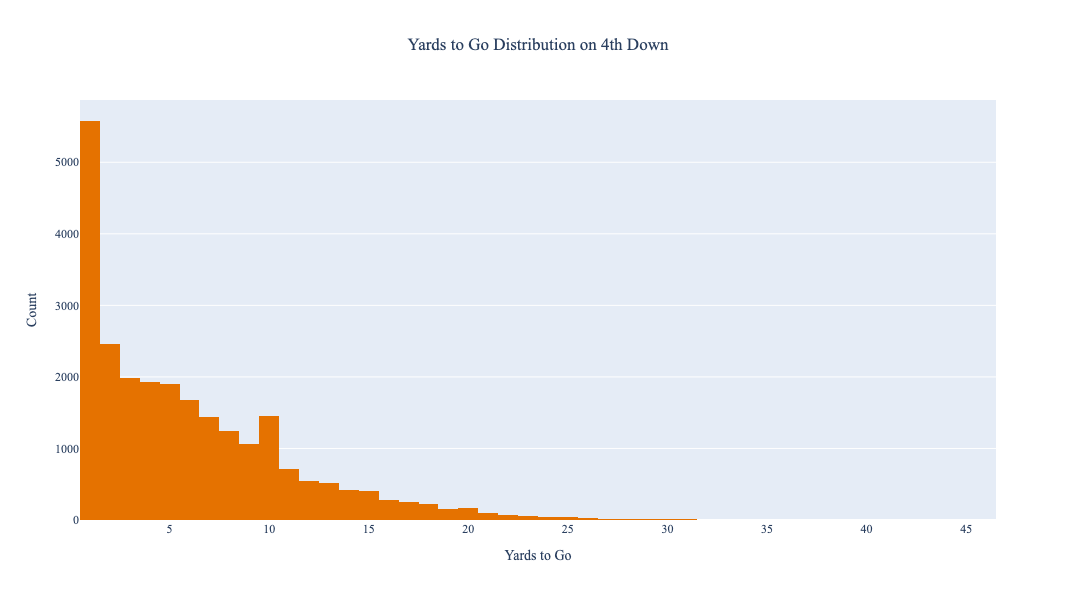

In [105]:
fig = px.histogram(
    yrdstogo['ydstogo'],
    nbins = 46,
    color_discrete_sequence = ['#E57200'],
    title = 'Yards to Go Distribution on 4th Down',
    width = 1000,
    height = 600
)

fig.update_layout(
    xaxis_title = 'Yards to Go',
    yaxis_title = 'Count',
    showlegend=False,
    title_x = 0.5,
    font_family = 'Times New Roman'
)

fig.show()

#### 3b. Yardline

24/11/30 14:43:13 WARN TaskSetManager: Stage 73 contains a task of very large size (2062 KiB). The maximum recommended task size is 1000 KiB.


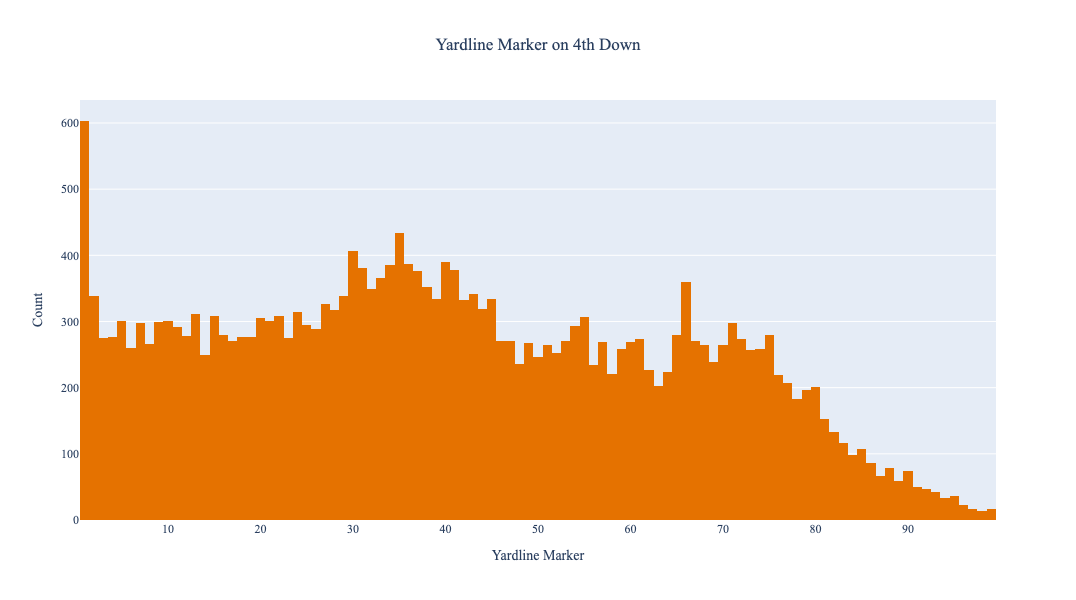

In [104]:
# histrogram of yards to go
yardline_100 = undersampled_df3.select('yardline_100').toPandas()

fig = px.histogram(
    yardline_100['yardline_100'],
    nbins = 100,
    color_discrete_sequence = ['#E57200'],
    title = 'Yardline Marker on 4th Down',
    width = 1000,
    height = 600
)

fig.update_layout(
    xaxis_title = 'Yardline Marker',
    yaxis_title = 'Count',
    showlegend=False,
    title_x = 0.5,
    font_family = 'Times New Roman'
)

fig.show()

#### 3c. Yards to Go and Play Type

In [81]:
import numpy as np

24/11/30 14:37:26 WARN TaskSetManager: Stage 68 contains a task of very large size (2062 KiB). The maximum recommended task size is 1000 KiB.


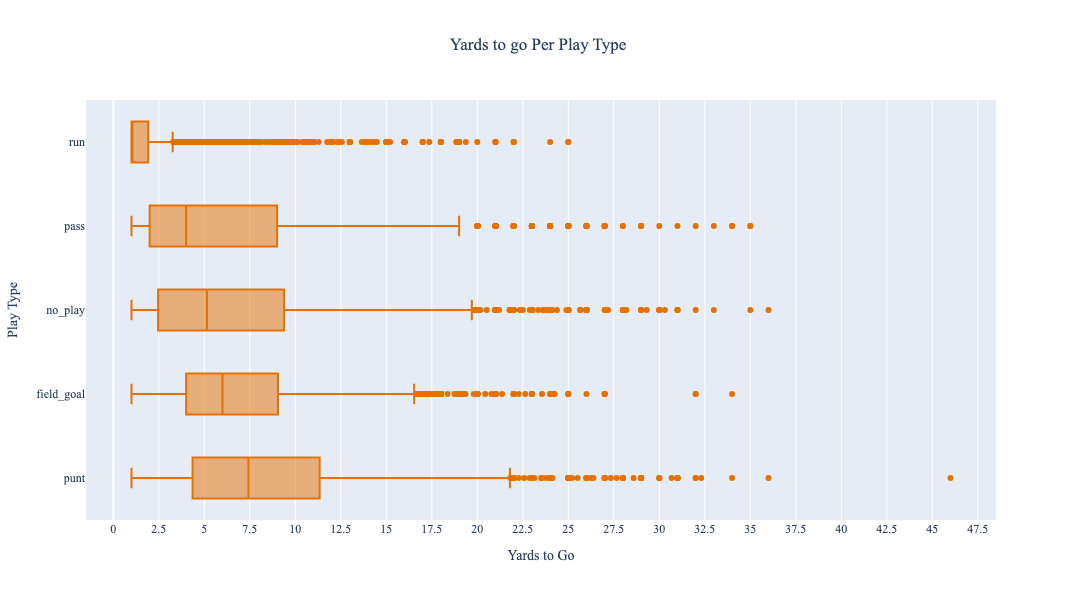

In [99]:
# histrogram of yards to go
df = undersampled_df3.select(['play_type', 'ydstogo']).toPandas()

fig = px.box(
    x = df['ydstogo'],
    y = df['play_type'],
    color_discrete_sequence = ['#E57200'],
    title = 'Yards to go Per Play Type',
    width = 1000,
    height = 600
)

fig.update_layout(
    yaxis_title = 'Play Type',
    xaxis_title = 'Yards to Go',
    showlegend=False,
    title_x = 0.5,
    font_family = 'Times New Roman',
    xaxis_tickvals = np.arange(50, step = 2.5),
    yaxis_categoryorder = 'mean descending'
)


fig.show()

#### 3d. 

24/11/30 14:56:35 WARN TaskSetManager: Stage 79 contains a task of very large size (2062 KiB). The maximum recommended task size is 1000 KiB.


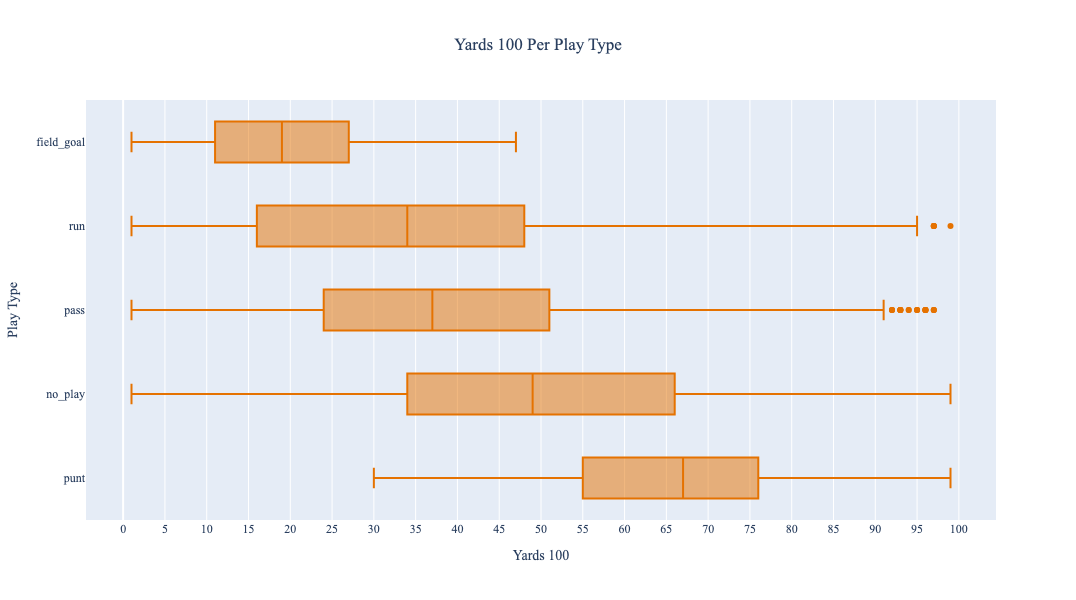

In [119]:
# histrogram of yards to go
df = undersampled_df3.select(['play_type', 'yardline_100']).toPandas()

fig = px.box(
    x = df['yardline_100'],
    y = df['play_type'],
    color_discrete_sequence = ['#E57200'],
    title = 'Yards 100 Per Play Type',
    width = 1000,
    height = 600
)

fig.update_layout(
    yaxis_title = 'Play Type',
    xaxis_title = 'Yards 100',
    showlegend=False,
    title_x = 0.5,
    font_family = 'Times New Roman',
    xaxis_tickvals = np.arange(105, step = 5),
    yaxis_categoryorder = 'mean descending'
)


fig.show()

### 4. Model Construction (3 Points)

#### 4a. Configure pipeline stages

In [20]:
from pyspark.ml import Pipeline  
from pyspark.ml.feature import *  
from pyspark.ml.classification import LogisticRegression


# process using string indexer first for catgeorical features  
stringIndexer = StringIndexer(inputCols=str_col, outputCols=str_col_output)

# process rating data into second feature
ohe = OneHotEncoder(inputCols=ohe_col_input, outputCols=ohe_col_vec) 

# Assemble features column
va = VectorAssembler(inputCols=ohe_col_vec, outputCol="features") 

# process data using maxabs scaler
#scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler = MaxAbsScaler(inputCol="features", outputCol="scaledFeatures")

lr = LogisticRegression(labelCol='play_type_idx', 
                        featuresCol='scaledFeatures')

# Fit the pipeline
pipeline = Pipeline(stages=[stringIndexer, ohe, va, scaler, lr])
#model = pipeline.fit(undersampled_df3)

#### 4b. Set up hyperparameter tuning

In [21]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.0, 0.1, 0.09, 0.05, 0.01, 0.005]) \
    .addGrid(lr.maxIter, [50, 100, 200])\
    .addGrid(lr.elasticNetParam, [0.0, 0.01, 0.5, 0.8, 0.85, 0.9, 1])\
    .build()

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",
                                          labelCol="play_type_idx",
                                          metricName="precisionByLabel")

tvs = TrainValidationSplit(estimator=pipeline,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)


#### 4c. Run TrainValidationSplit, and choose the best set of parameters.

In [22]:
model = tvs.fit(undersampled_df3)

24/11/30 05:24:33 WARN TaskSetManager: Stage 38 contains a task of very large size (2059 KiB). The maximum recommended task size is 1000 KiB.


24/11/30 05:24:34 WARN TaskSetManager: Stage 41 contains a task of very large size (2059 KiB). The maximum recommended task size is 1000 KiB.


24/11/30 05:24:35 WARN TaskSetManager: Stage 44 contains a task of very large size (2059 KiB). The maximum recommended task size is 1000 KiB.


24/11/30 05:24:37 WARN TaskSetManager: Stage 45 contains a task of very large size (2059 KiB). The maximum recommended task size is 1000 KiB.
24/11/30 05:24:37 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/11/30 05:24:37 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
24/11/30 05:24:37 WARN TaskSetManager: Stage 46 contains a task of very large size (2059 KiB). The maximum recommended task size is 1000 KiB.
24/11/30 05:24:38 WARN TaskSetManager: Stage 47 contains a task of very large size (2059 KiB). The maximum recommended task size is 1000 KiB.
24/11/30 05:24:38 WARN TaskSetManager: Stage 48 contains a task of very large size (2059 KiB). The maximum recommended task size is 1000 KiB.
24/11/30 05:24:38 WARN TaskSetManager: Stage 49 contains a task of very large size (2059 KiB). The maximum recommended task size is 1000 KiB.
24/11/30 05:24:38 WARN TaskSetManager: Stage 50 contains a task of very large s

24/11/30 05:24:42 WARN TaskSetManager: Stage 101 contains a task of very large size (2059 KiB). The maximum recommended task size is 1000 KiB.
24/11/30 05:24:43 WARN TaskSetManager: Stage 104 contains a task of very large size (2059 KiB). The maximum recommended task size is 1000 KiB.
24/11/30 05:24:43 WARN TaskSetManager: Stage 107 contains a task of very large size (2059 KiB). The maximum recommended task size is 1000 KiB.
24/11/30 05:24:44 WARN TaskSetManager: Stage 108 contains a task of very large size (2059 KiB). The maximum recommended task size is 1000 KiB.
24/11/30 05:24:44 WARN TaskSetManager: Stage 109 contains a task of very large size (2059 KiB). The maximum recommended task size is 1000 KiB.
24/11/30 05:24:44 WARN TaskSetManager: Stage 110 contains a task of very large size (2059 KiB). The maximum recommended task size is 1000 KiB.
24/11/30 05:24:44 WARN TaskSetManager: Stage 111 contains a task of very large size (2059 KiB). The maximum recommended task size is 1000 KiB.

#### 4d. Get best model after tuning hyperparameters

In [24]:
best_model = model.bestModel

# Extract the parameter map of the best model
best_params = best_model.stages[-1].extractParamMap()

# Print the parameters values
print("Tuned Parameters of the Best Model:")
for param, value in best_params.items():
    print(f"{param.name}: {value}")

Tuned Parameters of the Best Model:
aggregationDepth: 2
elasticNetParam: 1.0
family: auto
featuresCol: scaledFeatures
fitIntercept: True
labelCol: play_type_idx
maxBlockSizeInMB: 0.0
maxIter: 50
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
regParam: 0.01
standardization: True
threshold: 0.5
tol: 1e-06


#### 4e. Make predictions on test set using best model

In [25]:
prediction = best_model.transform(test_df)
prediction.select('play_type_idx', 'play_type','prediction').show(5, True)

24/11/30 05:31:21 WARN TaskSetManager: Stage 8742 contains a task of very large size (8307 KiB). The maximum recommended task size is 1000 KiB.
24/11/30 05:31:21 WARN TaskSetManager: Stage 8743 contains a task of very large size (8307 KiB). The maximum recommended task size is 1000 KiB.


+-------------+----------+----------+
|play_type_idx| play_type|prediction|
+-------------+----------+----------+
|          3.0|      punt|       2.0|
|          0.0|field_goal|       3.0|
|          3.0|      punt|       3.0|
|          3.0|      punt|       2.0|
|          3.0|      punt|       3.0|
+-------------+----------+----------+
only showing top 5 rows



#### 4f. See that classifer is not only predicting one play type due to class inbalance

In [26]:
prediction.groupBy("prediction").count().show()

24/11/30 05:31:33 WARN TaskSetManager: Stage 8751 contains a task of very large size (8307 KiB). The maximum recommended task size is 1000 KiB.
24/11/30 05:31:33 WARN TaskSetManager: Stage 8752 contains a task of very large size (8307 KiB). The maximum recommended task size is 1000 KiB.


+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 5872|
|       1.0|    5|
|       4.0|  180|
|       3.0|19988|
|       2.0|25601|
+----------+-----+



In [27]:
# pass to evaluator the DF with predictions, labels
precision = evaluator.evaluate(prediction)
#Need to check if this is correct
print("Precision:", precision)

24/11/30 05:31:42 WARN TaskSetManager: Stage 8765 contains a task of very large size (8307 KiB). The maximum recommended task size is 1000 KiB.
24/11/30 05:31:43 WARN TaskSetManager: Stage 8766 contains a task of very large size (8307 KiB). The maximum recommended task size is 1000 KiB.


Precision: 0.1965258855585831


#### 4g. Look at distribution of plays in test set. Plays are showing as name

In [28]:
prediction.groupBy("play_type").count().show()

24/11/30 05:31:49 WARN TaskSetManager: Stage 8775 contains a task of very large size (8307 KiB). The maximum recommended task size is 1000 KiB.
24/11/30 05:31:50 WARN TaskSetManager: Stage 8776 contains a task of very large size (8307 KiB). The maximum recommended task size is 1000 KiB.


+----------+-----+
| play_type|count|
+----------+-----+
|field_goal| 8931|
|   no_play| 1945|
|       run| 1999|
|      punt|35490|
|      pass| 3281|
+----------+-----+



#### 4h. Look at distribution of plays in test set. Plays are showing as index

In [29]:
prediction.groupBy("play_type_idx").count().show()

24/11/30 05:31:54 WARN TaskSetManager: Stage 8789 contains a task of very large size (8307 KiB). The maximum recommended task size is 1000 KiB.
24/11/30 05:31:54 WARN TaskSetManager: Stage 8790 contains a task of very large size (8307 KiB). The maximum recommended task size is 1000 KiB.


+-------------+-----+
|play_type_idx|count|
+-------------+-----+
|          0.0| 8931|
|          1.0| 1945|
|          4.0| 1999|
|          3.0|35490|
|          2.0| 3281|
+-------------+-----+



In [30]:
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics

#Adapting code from https://www.kaggle.com/code/ashokkumarpalivela/multiclass-classification-using-pyspark for confusion matrix
preds_and_labels = prediction.select(['prediction','play_type_idx'])\
                              .withColumn('play_type_idx', col('play_type_idx')\
                              .cast(FloatType()))\
                              .orderBy('prediction')
    
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

24/11/30 05:32:05 WARN TaskSetManager: Stage 8803 contains a task of very large size (8307 KiB). The maximum recommended task size is 1000 KiB.
24/11/30 05:32:05 WARN TaskSetManager: Stage 8804 contains a task of very large size (8307 KiB). The maximum recommended task size is 1000 KiB.


/opt/conda/lib/python3.7/site-packages/pyspark/sql/context.py:159: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



[[1.1540e+03 0.0000e+00 4.1520e+03 3.5910e+03 3.4000e+01]
 [2.0100e+02 0.0000e+00 1.0910e+03 6.4800e+02 5.0000e+00]
 [2.5800e+02 0.0000e+00 2.5540e+03 4.5900e+02 1.0000e+01]
 [4.0060e+03 5.0000e+00 1.6673e+04 1.4685e+04 1.2100e+02]
 [2.5300e+02 0.0000e+00 1.1310e+03 6.0500e+02 1.0000e+01]]


Text(95.58159722222221, 0.5, 'Actual')

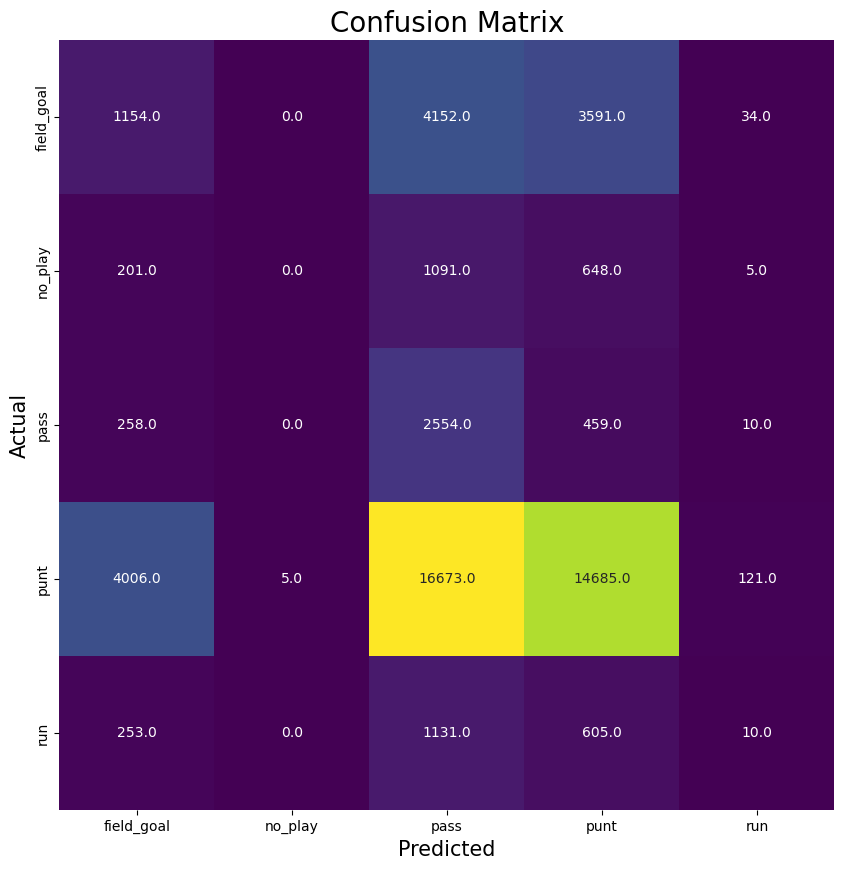

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["field_goal", "no_play", "pass", "punt", "run"]
_ = plt.figure(figsize=(10, 10))
ax = sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels,
            yticklabels=labels)

plt.title('Confusion Matrix', fontsize = 20) # title with fontsize 20
plt.xlabel('Predicted', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Actual', fontsize = 15) # y-axis label with fontsize 15

In [32]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
